#CRIC Skyra 2014

## Ghosting Analysis

In [15]:
from __future__ import division, print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pprint import pprint
import dicom as dcm
from dcmextras.siemenscsa import csa, phoenix
from mriqa.phantoms import phantom_mask_2d, find_phantom, TO1, TO2, TO3, TO4, OILSPHERE, GE10CMSPHERE
from mriqa.dcmio import fetch_series, seq_name, t_e, t_r, phase_enc_dirn
from mriqa.dcmio import approx_phase_orientation, approx_slice_orientation, num_frames, pix_spacing_yx
from mriqa.tools import mean_im, diff_im, snr_im, snr
from mriqa.ghosting import slice_ghostiness

from IPython.core.display import display

### Ghosting of GE 10cm sphere in Head Coil

#### AAPM Ghosting Measure

In [16]:
import skimage.draw as skidraw

def circular_mask(image, radius, centre_x, centre_y):
    '''Approximate circle mask as polygon.
    '''
    nsteps = 2 * np.pi * radius
    def xy(r, theta, c_x, c_y):
        return c_x + r*np.cos(theta), c_y + r*np.sin(theta)
    return mask_from_contour(image, [xy(radius, theta, centre_x, centre_y) for theta in np.linspace(0, 2*np.pi, nsteps)])


def rect_mask(image, xa, xb, ya, yb):
    '''Rectangular mask
    '''
    polygon = [(xb, ya), (xb, yb), (xa, yb), (xa, ya)]
    return mask_from_contour(image, polygon)

def mask_from_contour(image, contour):
    '''Return a mask image that has the same dimensions as the input image and
       True values on the *interior* of the given contour. Contour is as an n-by-2
       array.
    '''
    # nb: exchange x and y as the image array is organised y, x
    contour = np.asarray(contour)
    rr, cc = skidraw.polygon(contour[:, 1], contour[:, 0])
    mask = np.zeros(image.shape, dtype=bool)
    mask[rr, cc] = 1
    return mask

In [17]:
from scipy.ndimage.interpolation import zoom
from matplotlib.colors import ListedColormap

def ghost_report(patid, stuid, sernos, phantom):
    '''Report on ghosting for images acquired of specified phantom.
       Produces image plots and text output
    '''
    # Get series from Server
    dobjs = fetch_series(patid, stuid, sernos)
    dobj = dobjs[0]

    # Acquisition parameters
    print('Frames      = %d'          % num_frames(dobj))
    print('TR/TE       = %d / %d ms'  % (t_r(dobj), t_e(dobj)))
    print('Matrix      = %d x %d'     % (dobj.Rows, dobj.Columns))
    print('Sequence    = %s'          % seq_name(dobj))
    print('FoV         = %d x %d mm'  % (dobj.Rows * pix_spacing_yx(dobj)[0], dobj.Columns * pix_spacing_yx(dobj)[1]))
    print('Bandwidth   = %d Hz/pixel' % dobj.PixelBandwidth)
    print('PhaseEncode = %s'          % phase_enc_dirn(dobj))
    print('Protocol    = %s'          % dobj.ProtocolName)
    print('Orientation = %s'          % approx_slice_orientation(dobj))

    # Image data
    image = dobj.pixel_array
    pix_dims = pix_spacing_yx(dobj)
    assert np.allclose(pix_dims[0], pix_dims[1])

    # Use the first frame only of a multiframe
    if num_frames(dobj) > 1:
        image = image[0]

    # Interpolate up to 256*256 if less
    old_ny, old_nx = image.shape
    if old_ny < 256:
        image = zoom(image, zoom=256.0/old_ny)
        
        print(image.shape)
        ny, nx = image.shape
        pix_dims =  pix_dims[0]*(old_ny / ny), pix_dims[1]*(old_nx / nx)
    else:
        ny, nx = old_ny, old_nx

    # Find the phantom
    expected_radius = phantom['Diameter'] / 2 / pix_dims[0]
    centre_x, centre_y, radius = find_phantom(image, expected_radius=expected_radius)

    # phantom ROI
    phantom_mask = circular_mask(image, 0.85 * radius, centre_x, centre_y)
    margin_w = centre_x - 1.25 * radius
    margin_e = centre_x + 1.25 * radius
    margin_n = centre_y - 1.25 * radius
    margin_s = centre_y + 1.25 * radius
    
    # ghost ROIs
    ny, nx = image.shape
    ghost_mask_w = rect_mask(image, 0, margin_w, margin_n, margin_s)
    ghost_mask_e = rect_mask(image, margin_e, nx, margin_n, margin_s)
    ghost_mask_n = rect_mask(image, margin_w, margin_e, 0, margin_n)
    ghost_mask_s = rect_mask(image, margin_w, margin_e, margin_s, ny)
    
    # intensities in ROIs
    s_p = np.ma.masked_where(~phantom_mask, image).mean()
    s_n = np.ma.masked_where(~ghost_mask_n, image).mean()
    s_s = np.ma.masked_where(~ghost_mask_s, image).mean()
    s_e = np.ma.masked_where(~ghost_mask_e, image).mean()
    s_w = np.ma.masked_where(~ghost_mask_w, image).mean()
    
    # ghost ratio
    aapm_gr = abs(((s_w + s_e) - (s_n + s_s)) / (2 * s_p))
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(image, cmap='bone')

    axs[0].imshow(phantom_mask, cmap='rainbow', alpha=0.25)
    axs[0].axis('image')
    axs[0].axis('off')
    axs[0].add_artist(plt.Circle((centre_x, centre_y), radius=radius, color='r', fill=False))
    axs[0].set_title('Standard Windowing')

    mask_cmap = ListedColormap([(0,0,0), (0,0,1), (0,1,0), (1,0,0)])
    axs[1].imshow(np.where(image>0, image, 0), cmap='cubehelix', vmax=0.02*np.amax(image))
    axs[1].imshow(ghost_mask_n | ghost_mask_s | ghost_mask_e | ghost_mask_w, vmax=1, cmap=mask_cmap, alpha=0.25)

    axs[1].axis('image')
    axs[1].axis('off')
    axs[1].set_title('Ghost Windowing')

    fig.suptitle('Ghosting [%s]: Image %d:%d' % (seq_name(dobj), dobj.SeriesNumber, dobj.InstanceNumber), fontsize=16)
    plt.show()

    for name, value in zip(['Phantom', 'Left', 'Right', 'Top', 'Bottom'], [s_p, s_w, s_e, s_n, s_s]):
        print('%7s signal = %3.5f' % (name, value))
    print('       AAPM GR = %5.3f%%' % (100 * aapm_gr))

    results = [
        ('Series',         [dobj.SeriesNumber]),
        ('Frames',         [num_frames(dobj)]),
        ('TR',             [t_r(dobj)]),
        ('TE',             [t_e(dobj)]),
        ('Matrix',         [(dobj.Rows, dobj.Columns)]),
        ('Sequence',       [seq_name(dobj)]),
        ('FoV',            [(dobj.Rows * pix_spacing_yx(dobj)[0], dobj.Columns * pix_spacing_yx(dobj)[1])]),
        ('Bandwidth',      [dobj.PixelBandwidth]),
        ('PhaseAxis',      [phase_enc_dirn(dobj)]),
        ('PhaseDirection', [approx_phase_orientation(dobj)]),
        ('Protocol',       [dobj.ProtocolName]),
        ('SequenceCode',   [dobj.ProtocolName.split('_')[0]]),
        ('Orientation',    [approx_slice_orientation(dobj)]),
        ('Phantom',        [s_p]),
        ('Left',           [s_w]),
        ('Right',          [s_e]),
        ('Top',            [s_n]),
        ('Bottom',         [s_s]),
        ('GhostRatio',     [100 * aapm_gr])
    ]

    return pd.DataFrame.from_items(results).set_index('Series')

In [18]:
# Study details
patid = 'PQA20150309CRIC'
studyid = '1'
sernos = [14, 16, 18, 20, 21, 22, 24, 26]
results = None

##### Spin Echo

Frames      = 1
TR/TE       = 500 / 30 ms
Matrix      = 256 x 256
Sequence    = *se2d1
FoV         = 250 x 250 mm
Bandwidth   = 130 Hz/pixel
PhaseEncode = ROW
Protocol    = SE_AXIAL_RL_GHOST_HEAD_GE10CM_PSN
Orientation = Axial


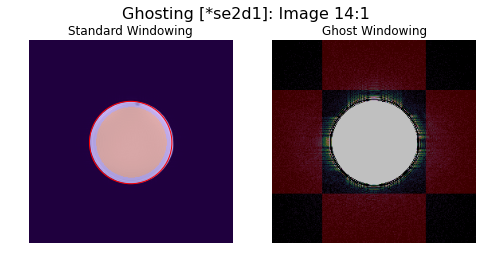

Phantom signal = 797.21527
   Left signal = 0.64957
  Right signal = 0.62161
    Top signal = 0.43462
 Bottom signal = 0.51328
       AAPM GR = 0.020%


In [19]:
result = ghost_report(patid, studyid, sernos=sernos[0], phantom=GE10CMSPHERE)
results = result if results is None else results.append(result)

Frames      = 1
TR/TE       = 500 / 30 ms
Matrix      = 256 x 256
Sequence    = *se2d1
FoV         = 250 x 250 mm
Bandwidth   = 130 Hz/pixel
PhaseEncode = COL
Protocol    = SE_AXIAL_AP_GHOST_HEAD_GE10CM_PSN
Orientation = Axial


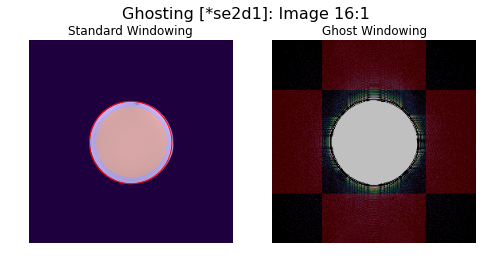

Phantom signal = 797.04462
   Left signal = 0.40720
  Right signal = 0.43211
    Top signal = 0.79159
 Bottom signal = 0.89156
       AAPM GR = 0.053%


In [20]:
result = ghost_report(patid, studyid, sernos=sernos[1], phantom=GE10CMSPHERE)
results = result if results is None else results.append(result)

##### Turbo Spin Echo

Frames      = 1
TR/TE       = 6000 / 104 ms
Matrix      = 256 x 256
Sequence    = *tse2d1_18
FoV         = 250 x 250 mm
Bandwidth   = 220 Hz/pixel
PhaseEncode = ROW
Protocol    = TSE_AXIAL_RL_GHOST_HEAD_GE10CM_PSN
Orientation = Axial


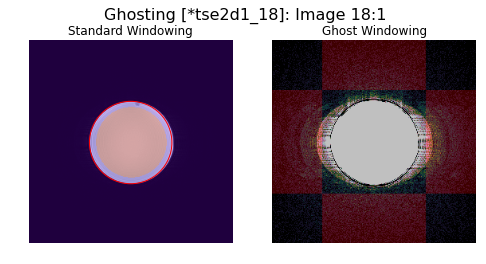

Phantom signal = 411.54600
   Left signal = 1.02637
  Right signal = 1.23541
    Top signal = 0.57452
 Bottom signal = 0.75186
       AAPM GR = 0.114%


In [21]:
result = ghost_report(patid, studyid, sernos=sernos[2], phantom=GE10CMSPHERE)
results = result if results is None else results.append(result)

Frames      = 1
TR/TE       = 6000 / 104 ms
Matrix      = 256 x 256
Sequence    = *tse2d1_18
FoV         = 250 x 250 mm
Bandwidth   = 220 Hz/pixel
PhaseEncode = COL
Protocol    = TSE_AXIAL_AP_GHOST_HEAD_GE10CM_PSN
Orientation = Axial


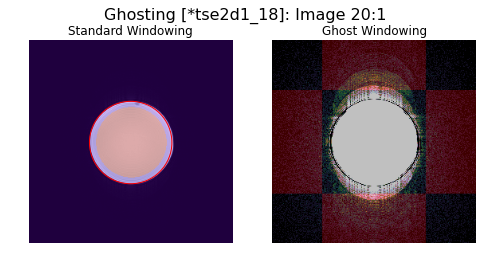

Phantom signal = 412.10161
   Left signal = 0.58889
  Right signal = 0.56960
    Top signal = 1.09471
 Bottom signal = 1.35199
       AAPM GR = 0.156%


In [22]:
result = ghost_report(patid, studyid, sernos=sernos[3], phantom=GE10CMSPHERE)
results = result if results is None else results.append(result)

##### Echo Planar Imaging

Frames      = 1
TR/TE       = 2000 / 30 ms
Matrix      = 64 x 64
Sequence    = *epfid2d1_64
FoV         = 250 x 250 mm
Bandwidth   = 3125 Hz/pixel
PhaseEncode = ROW
Protocol    = EP2D_AXIAL_RL_GHOST_HEAD_GE10CM_PSN
Orientation = Axial
(256, 256)


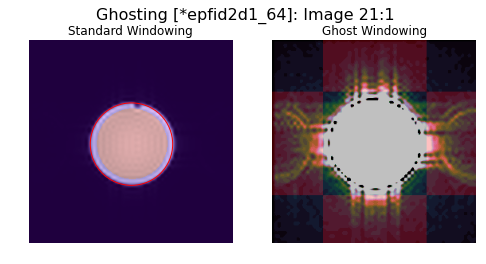

Phantom signal = 883.56782
   Left signal = 5.17981
  Right signal = 5.64231
    Top signal = 3.57261
 Bottom signal = 4.36487
       AAPM GR = 0.163%


In [23]:
result = ghost_report(patid, studyid, sernos=sernos[4], phantom=GE10CMSPHERE)
results = result if results is None else results.append(result)

Frames      = 1
TR/TE       = 2000 / 30 ms
Matrix      = 64 x 64
Sequence    = *epfid2d1_64
FoV         = 250 x 250 mm
Bandwidth   = 3125 Hz/pixel
PhaseEncode = COL
Protocol    = EP2D_AXIAL_AP_GHOST_HEAD_GE10CM_PSN
Orientation = Axial
(256, 256)


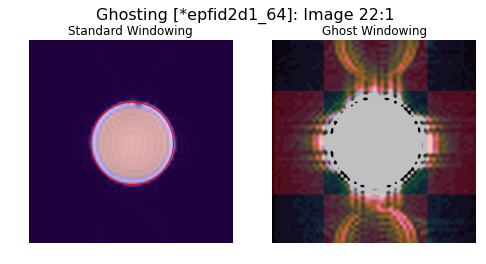

Phantom signal = 879.27406
   Left signal = 3.53905
  Right signal = 3.89533
    Top signal = 5.59467
 Bottom signal = 6.70631
       AAPM GR = 0.277%


In [24]:
result = ghost_report(patid, studyid, sernos=sernos[5], phantom=GE10CMSPHERE)
results = result if results is None else results.append(result)

##### Spin Echo EPI

Frames      = 1
TR/TE       = 294 / 189 ms
Matrix      = 128 x 128
Sequence    = *epse2d1_128
FoV         = 250 x 250 mm
Bandwidth   = 750 Hz/pixel
PhaseEncode = ROW
Protocol    = EPSE_AXIAL_RL_GHOST_HEAD_GE10CM_PSN
Orientation = Axial
(256, 256)


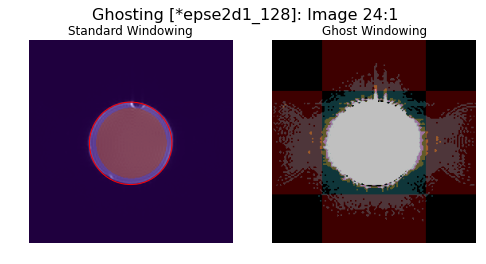

Phantom signal = 87.12001
   Left signal = 0.46227
  Right signal = 0.45165
    Top signal = 0.12320
 Bottom signal = 0.22257
       AAPM GR = 0.326%


In [25]:
result = ghost_report(patid, studyid, sernos=sernos[6], phantom=GE10CMSPHERE)
results = result if results is None else results.append(result)

Frames      = 1
TR/TE       = 294 / 189 ms
Matrix      = 128 x 128
Sequence    = *epse2d1_128
FoV         = 250 x 250 mm
Bandwidth   = 750 Hz/pixel
PhaseEncode = COL
Protocol    = EPSE_AXIAL_AP_GHOST_HEAD_GE10CM_PSN
Orientation = Axial
(256, 256)


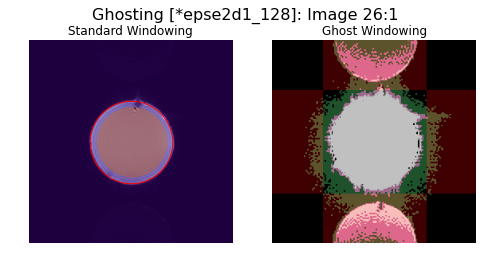

Phantom signal = 87.46165
   Left signal = 0.12512
  Right signal = 0.14243
    Top signal = 0.96394
 Bottom signal = 1.36749
       AAPM GR = 1.180%


In [26]:
result = ghost_report(patid, studyid, sernos=sernos[7], phantom=GE10CMSPHERE)
results = result if results is None else results.append(result)

##Ghosting Ratios
This table summarises the *Ghost Ratio*, the main result for each scan. 

In [27]:
display(results[['Protocol', 'SequenceCode', 'Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']])

Protocol SequenceCode      Sequence  \
Series                                                                   
14        SE_AXIAL_RL_GHOST_HEAD_GE10CM_PSN           SE        *se2d1   
16        SE_AXIAL_AP_GHOST_HEAD_GE10CM_PSN           SE        *se2d1   
18       TSE_AXIAL_RL_GHOST_HEAD_GE10CM_PSN          TSE    *tse2d1_18   
20       TSE_AXIAL_AP_GHOST_HEAD_GE10CM_PSN          TSE    *tse2d1_18   
21      EP2D_AXIAL_RL_GHOST_HEAD_GE10CM_PSN         EP2D  *epfid2d1_64   
22      EP2D_AXIAL_AP_GHOST_HEAD_GE10CM_PSN         EP2D  *epfid2d1_64   
24      EPSE_AXIAL_RL_GHOST_HEAD_GE10CM_PSN         EPSE  *epse2d1_128   
26      EPSE_AXIAL_AP_GHOST_HEAD_GE10CM_PSN         EPSE  *epse2d1_128   

       Orientation PhaseDirection  GhostRatio  
Series                                         
14           Axial             RL        0.02  
16           Axial             AP        0.05  
18           Axial             RL        0.11  
20           Axial             AP        0.16  
21           Axial             RL        0.16  
22           Axial             AP        0.28  
24           Axial             RL        0.33  
26           Axial             AP        1.18

##Summary
For each table this summarises the the worst ghosting and the axis it was found on. 

In [28]:
def top(df, column='GhostRatio'):
    return df.sort_index(by=column)[-1:]
pd.set_option('display.precision', 3)
summary = results.groupby('SequenceCode').apply(top)[['Orientation','PhaseDirection', 'GhostRatio']].sortlevel(1)
display(summary)

Orientation PhaseDirection  GhostRatio
SequenceCode Series                                       
SE           16           Axial             AP        0.05
TSE          20           Axial             AP        0.16
EP2D         22           Axial             AP        0.28
EPSE         26           Axial             AP        1.18